References:
- https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/ResNet.ipynb
- https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

from functools import partial
from collections import OrderedDict

import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25

In [2]:
class Conv2dPad(nn.Conv2d):
    '''Custom Conv2D class to handle padding'''
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Automatically sets the padding based on the kernel size
        self.padding = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)

In [3]:
# Using partial to create proxy class that forwards some args by default
# This is basically a shortcut to calling Conv2d(kernel_size=3, bias=False)
Conv3x3 = partial(Conv2dPad, kernel_size=3, bias=False)

In [115]:
# For example
Conv3x3(in_channels=32, out_channels=64)

Conv2dPad(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [5]:
# Helper function that returns a Conv. followed by a batch norm, forwards all args to conv layer
def create_conv_bn(in_dim, out_dim, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({
            'Convolution' : conv(in_dim, out_dim, *args, **kwargs),
            'Batch Norm' : nn.BatchNorm2d(out_dim)
        }))

In [120]:
class ResidualBlock(nn.Module):
    '''
    Base class for each type of residual block. Keeps track of the dimensions and specifies
    the shortcut to use, if necessary. The main conv blocks should be put into `self.blocks`
    '''
    def __init__(self, in_dim, out_dim, expansion=1, downsampling=1, conv=Conv3x3, *args, **kwargs):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.expansion = expansion
        self.downsampling = downsampling
        self.conv = conv
        self.blocks = nn.Identity()

        self.expanded_dim = self.out_dim * self.expansion
        self.apply_shortcut = self.in_dim != self.expanded_dim

        if self.apply_shortcut:
            self.shortcut = create_conv_bn(in_dim, self.expanded_dim, nn.Conv2d, kernel_size=1, stride=self.downsampling, bias=False)
        else:
            # If the dimensions line up, the input will be passed directly through the residual path
            # Make this None so that it doesn't appear when printing the  
            self.shortcut = None

    # Main forward call
    def forward(self, x):
        residual = x
        if self.apply_shortcut:
            residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x

In [121]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (shortcut): Sequential(
    (Convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Batch Norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [133]:
class BasicBlock(ResidualBlock):
    """ Basic ResNet block, has two convs with a Relu in between, each with a batch norm
    """
    # Static property
    expansion = 1
    def __init__(self, in_dim, out_dim, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_dim, out_dim, *args, **kwargs)
        self.blocks = nn.Sequential(
            create_conv_bn(self.in_dim, self.out_dim, self.conv, bias=False, stride=self.downsampling),
            activation(),
            create_conv_bn(self.out_dim, self.expanded_dim, self.conv, bias=False),
        )

In [124]:
block = BasicBlock(32, 64)
print(block)
# Should be 64 deep
print(block(torch.ones(1, 32, 224, 224)).shape)

BasicBlock(
  (blocks): Sequential(
    (0): Sequential(
      (Convolution): Conv2dPad(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (Batch Norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (Convolution): Conv2dPad(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (Batch Norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (Convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Batch Norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([1, 64, 224, 224])


In [125]:
class BottleNeckBlock(ResidualBlock):
    """Applies a 1x1 conv, 3x3 conv (with downsampling using strides), and then 1x1 conv
    Each has a Relu and batch norm in between
    """
    # Static property
    expansion = 4
    def __init__(self, in_dim, out_dim, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_dim, out_dim, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            create_conv_bn(self.in_dim, self.out_dim, self.conv, kernel_size=1),
            activation(),
            create_conv_bn(self.out_dim, self.out_dim, self.conv, kernel_size=3, stride=self.downsampling),
            activation(),
            create_conv_bn(self.out_dim, self.expanded_dim, self.conv, kernel_size=1)
        )

In [127]:
block = BottleNeckBlock(32, 64)
print(block)
# Should be 256 deep
print(block(torch.ones(1, 32, 10, 10)).shape)

BottleNeckBlock(
  (blocks): Sequential(
    (0): Sequential(
      (Convolution): Conv2dPad(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (Batch Norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (Convolution): Conv2dPad(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (Batch Norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (Convolution): Conv2dPad(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (Batch Norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (Convolution): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Batch Norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([1, 256, 10, 10])


In [131]:
@

In [194]:
layer = ResNetLayer(64, 128, BottleNeckBlock, n=3)
print(layer)
print(layer(torch.ones(1, 64, 100, 100)).shape)

ResNetLayer(
  (residual_blocks): ModuleList(
    (0): BottleNeckBlock(
      (blocks): Sequential(
        (0): Sequential(
          (Convolution): Conv2dPad(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (Batch Norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU()
        (2): Sequential(
          (Convolution): Conv2dPad(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (Batch Norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (3): ReLU()
        (4): Sequential(
          (Convolution): Conv2dPad(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (Batch Norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (shortcut): Sequential(
        (Convolution): Conv2d(64, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (Batch Norm): Bat

In [167]:
a = [1,2,3,4]
list(zip(a, a[1:]))

[(1, 2), (2, 3), (3, 4)]

In [195]:
class ResNet(nn.Module):
    """Full ResNet Model
    Contains an initial input gate, and then multiple ResNet layers, followed by a 
    """
    def __init__(self, in_dim, num_classes, activation=nn.ReLU, block_sizes=[64, 128, 256, 512], depths=[2,2,2,2], *args,**kwargs):
        super().__init__()
        if 'block_type' not in kwargs:
            raise RuntimeError('Must specify block_type!')
        
        if len(block_sizes) != len(depths):
            raise RuntimeError('Expected same length for block sizes and depths, but got %s and %s'%(len(block_sizes), len(depths)))

        block_type = kwargs['block_type']
        
        # Initial input gate, reduces the dimensionality of the image, and makes the channels match
        # that of the first block
        self.gate = nn.Sequential(
            nn.Conv2d(in_dim, block_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(block_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layers = nn.ModuleList()
        self.layers.append(ResNetLayer(block_sizes[0], block_sizes[0], n=depths[0], activation=activation, *args, **kwargs))
        for i in range(1, len(block_sizes)):
            layer_in_dim = block_sizes[i - 1]
            layer_out_dim = block_sizes[i] 
            self.layers.append(ResNetLayer(layer_in_dim * block_type.expansion, layer_out_dim, n=depths[i], activation=activation, *args, **kwargs))

        last_block = self.layers[-1].residual_blocks[-1]
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(last_block.out_dim * last_block.expansion, num_classes)

    def forward(self, x):
        # Initial gating
        x = self.gate(x)

        # Conv residual blocks
        for layer in self.layers:
            x = layer(x)
        
        # Final FC layer
        x = self.avg(x)
        # Flatten output
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

In [22]:
batch_size = 64
# Mean and std for CIFAR-10
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

dataset_dir = '../data/'

# Get CIFAR train and test data loaders
train_dataset = torchvision.datasets.CIFAR10(
    dataset_dir, train=True, transform=train_transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(
    dataset_dir, train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [81]:
def test(model, test_loader, loss_fcn):
    """Function to run the test data in the `test_loader`
    Returns: tuple of accuracy and average loss
    """
    num_correct = 0
    avg_loss = 0
    for step, (data, targets) in enumerate(test_loader):
        data = data.cuda()
        targets = targets.cuda()

        with torch.no_grad():
            preds = model(data)

        loss = loss_fcn(preds, targets)
        avg_loss += loss.item()

        _, pred_labels = torch.max(preds, dim=1)
        
        num_correct += pred_labels.eq(targets).sum().item()

    # Because used a sum, make sure to divide by the length of total number in dataset
    acc = num_correct/len(test_loader.dataset)
    avg_loss /= len(test_loader)

    return acc, avg_loss

## Training!

In [196]:
# Some hyper params
base_lr = 0.1
momentum = 0.9
weight_decay = 1e-4
lr_decay = 0.1
epochs = 10
log_freq = 150

# ResNet50
model = ResNet(3, 10, block_type=BottleNeckBlock, depths=[3, 4, 6, 3])
model.cuda()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[80, 120],
    gamma=lr_decay)

loss_fcn = nn.CrossEntropyLoss(size_average=True)

train_losses = []
test_losses = []
test_accuracy = []
test_idxs = []
batch_count = 0
for epoch in range(epochs):
    print('-'*20)
    print('Starting epoch #%s'%epoch)
    scheduler.step()

    for step, (data, targets) in enumerate(train_loader):
        batch_count += 1

        # Move data to gpu
        data = data.cuda()
        targets = targets.cuda()

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)
        # Backprop
        loss = loss_fcn(outputs, targets)
        loss.backward()
        
        # Step optimizer
        optimizer.step()

        # Keep track of history
        train_losses.append(loss.item())

        if step % log_freq == 0:
            acc, test_loss = test(model, test_loader, criterion)
            test_losses.append(test_loss)
            test_accuracy.append(acc)
            test_idxs.append(batch_count)
            print('Step: %s/%s | Loss: %.4f | Test accuracy: %.2f%%'%(step, len(train_loader), np.mean(train_losses), acc*100))

--------------------
Starting epoch #0
Step: 0/781 | Loss: 2.8612 | Test accuracy: 11.09%
Step: 150/781 | Loss: 19.6386 | Test accuracy: 17.16%
Step: 300/781 | Loss: 11.0433 | Test accuracy: 17.15%
Step: 450/781 | Loss: 8.1115 | Test accuracy: 17.89%
Step: 600/781 | Loss: 6.6275 | Test accuracy: 21.18%
Step: 750/781 | Loss: 5.7283 | Test accuracy: 23.89%
--------------------
Starting epoch #1
Step: 0/781 | Loss: 5.5834 | Test accuracy: 23.96%
Step: 150/781 | Loss: 5.0191 | Test accuracy: 23.10%
Step: 300/781 | Loss: 4.6069 | Test accuracy: 25.30%
Step: 450/781 | Loss: 4.2921 | Test accuracy: 26.01%
Step: 600/781 | Loss: 4.0444 | Test accuracy: 26.63%
Step: 750/781 | Loss: 3.8434 | Test accuracy: 26.10%
--------------------
Starting epoch #2
Step: 0/781 | Loss: 3.8076 | Test accuracy: 24.80%
Step: 150/781 | Loss: 3.6462 | Test accuracy: 27.88%
Step: 300/781 | Loss: 3.5102 | Test accuracy: 28.35%
Step: 450/781 | Loss: 3.3919 | Test accuracy: 31.82%
Step: 600/781 | Loss: 3.2871 | Test acc

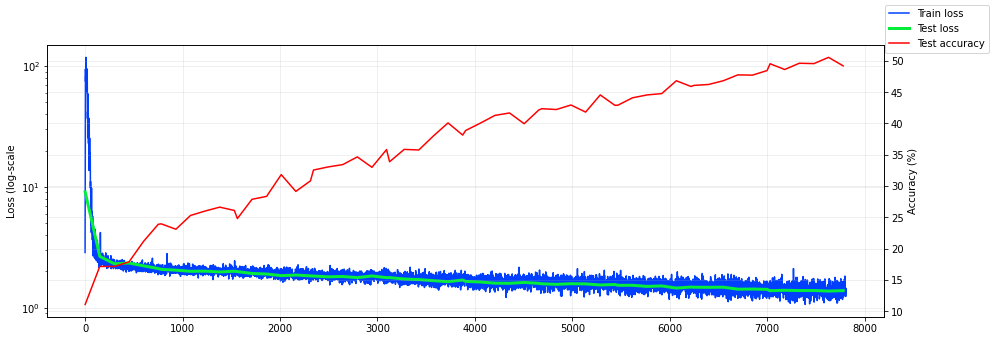

In [197]:
fig, axs = plt.subplots()
axs.plot(train_losses)
axs.plot(test_idxs, test_losses, linewidth=3)
axs.set_yscale('log')
axs.set_ylabel('Loss (log-scale')

acc_axs = axs.twinx()
acc_axs.plot(test_idxs, 100*np.array(test_accuracy), 'r')
acc_axs.set_ylabel('Accuracy (%)')

_ = fig.legend(['Train loss', 'Test loss', 'Test accuracy'])

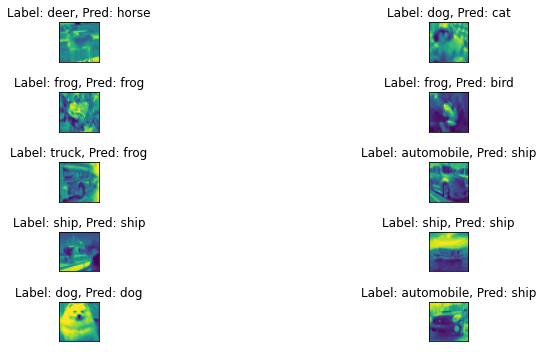

In [211]:
model.eval()
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(10):
    rand_index = np.random.randint(0, len(test_dataset))
    rand_img = test_dataset[rand_index][0]
    gt_label = test_dataset.classes[test_dataset[rand_index][1]]
    
    preds = model(rand_img.view(1, 3, 32, 32).cuda())
    pred_label = test_dataset.classes[preds.argmax().cpu().numpy()]

    axs[i].imshow(rand_img.numpy()[0])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title('Label: %s, Pred: %s'%(gt_label, pred_label))
plt.tight_layout()
plt.show()

# Takeaways from Working Through a Complete ResNet Example
Coding ResNet from scratch was an extremely valuable experience. Even though torchvision has a built-in ResNet module that could have easily been used, anyone can write a couple of lines and use the top-notch pre trained model. I learned a lot from doing it myself. The way in which I learn best is to follow examples, which is what I did here. My strategy is to still write the code fully by scratch. That is, even if I am using something word for word, I type it all out and usually change some little things such as variable names. This way, I am forced to read the code word for word, and pay more attention, since I have to think about how things work to make sure I change the variables correctly. It also opens the door for the way we learn best: Bugs! I have been writing software for about 7 years, and I can maybe count on my fingers how many times a piece of code has worked the first try. By introducing bugs, it actually allows for a deeper inspection of the code, which forces one to really understand what is going on. Tracking down bugs also improves your debugging, one of the most valuable to things to learn as a software engineer. In this case, it is a new skill: debugging deep learning code, which can be really tricky. 

In this case, the bug had to do with dimensions of some of the residual blocks. There were two mistakes I made:
- When checking if the block should use the shortcut (see `apply_shortcut()` within the base class `ResidualBlock`) I was checking if `in_dim == out_dim`. This should have checked if `in_dim == expansion*out_dim`. This had worked for the basic block (since `expansion` is 1), but was failing to apply the correct shortcut to the bottleneck block.
- When creating the `ResNetEncoder` layer, I had been passing in the type of block as the parameter `block`, when I had actually named it `block_type` in the constructor of the `ResNetLayer`. This was not caught as a runtime error, since I forward `args` and `kwargs` within the constructor, so the extra keyworkd is valid. The base class was using the default value (`BasicBlock`), which has an expansion of `1` even though the dimensions were changing. Oh how I miss C++! This bug was super hard to find.

Both bugs were dimension related, so finding them involved printing the structure of each of the pieces that make up the network. In addition, I had to pass in tensors of all ones in order to test out the forward pass explicitly. I am very glad I spent alot time last week going over dimensionality of convolutional networks, so that I understood how things fit together. All in all, I spent around 2 hours just finding these bugs, but I truly belive it was time well spent, since I developed strategies that I can use in the future to debug the code that creates and trains networks.